# TP2: Linear Regression

*By Daniel Jorge Deutsch*

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LassoCV, LinearRegression, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [23]:
sns.set(font_scale=1.5)

# Exercise 1.1

In [24]:
# Load the data and sort the dataframe columns
df = pd.read_csv("./datasets/data_tp_2.csv")
# df = df.reindex(sorted(df.columns, key=lambda x: (len(x), x.lower())), axis=1)   # This line changes the results in exercise 10

# Separates the df into input (X) and output (Y) matrices
X = df[[col for col in df.columns if col.startswith("X")]].values
Y = df[[col for col in df.columns if col.startswith("Y")]].values

# Obtains the dimensions of X
n, p = X.shape

# Separates the covariate data in train and test sets (test should be 25% of total)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)
print(f"Size of the training set: {X_train.shape[0]}")
print(f"Size of the test set: {X_test.shape[0]}")

# Center and standarize the train and test data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Create empty DataFrames
df_test = pd.DataFrame()
df_coef = pd.DataFrame()

Size of the training set: 379
Size of the test set: 127


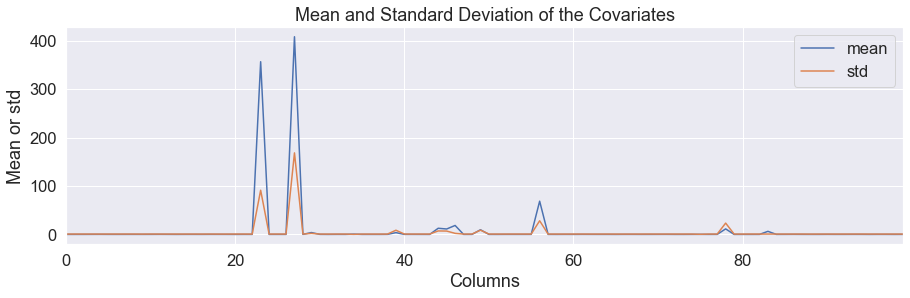

In [25]:
# Plot the mean and standard deviation of the covariates
plt.figure(figsize=(15, 4))
plt.plot(X.mean(axis=0), label="mean")
plt.plot(X.std(axis=0), label="std")
plt.xlim(0, p-1)
plt.title("Mean and Standard Deviation of the Covariates")
plt.xlabel("Columns")
plt.ylabel("Mean or std")
plt.legend()
plt.show()

As one can see from the plot above, the data is **not centered** since $E[X_i] \neq 0$. We can also notice that the data is **not normalized** since $\sigma_i \neq 1$. Thherefore, we can say that the data is **not standardized**. ** FALTA FALAR STANDARDIZEDDDDDDDD**

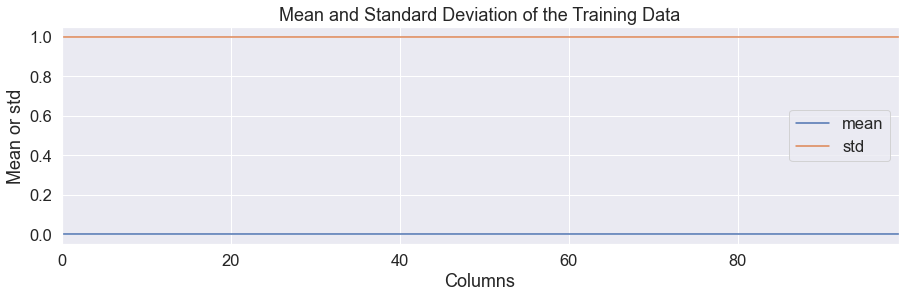

In [26]:
# Plot the mean and standard deviation of the trainig data
plt.figure(figsize=(15, 4))
plt.plot(X_train.mean(axis=0), label="mean")
plt.plot(X_train.std(axis=0), label="std")
plt.xlim(0, p-1)
plt.title("Mean and Standard Deviation of the Training Data")
plt.xlabel("Columns")
plt.ylabel("Mean or std")
plt.legend()
plt.show()

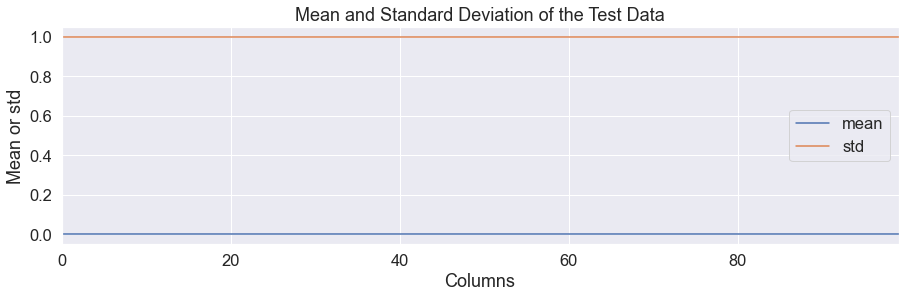

In [27]:
# Plot the mean and standard deviation of the test data
plt.figure(figsize=(15, 4))
plt.plot(X_test.mean(axis=0), label="mean")
plt.plot(X_test.std(axis=0), label="std")
plt.xlim(0, p-1)
plt.title("Mean and Standard Deviation of the Test Data")
plt.xlabel("Columns")
plt.ylabel("Mean or std")
plt.legend()
plt.show()

# Exercise 1.2 

In [28]:
def R2(Y_test, Y_test_pred):
    RSS = ( (Y_test-Y_test_pred)**2 ).sum()
    TSS = ( (Y_test-Y_test.mean())**2 ).sum()
    r2 = 1 - RSS/TSS
    return r2

def MSE(Y_test, Y_test_pred):    
    mse = ( (Y_test_pred-Y_test)**2 ).mean(axis=0)[0]
    return mse

# Exercise 1.3

In [29]:
# Creates a model with the training data
model = LinearRegression()            # Creates the model
model = model.fit(X_train, Y_train)   # Trains the model

# Predicts Y_test using the model and X_test as input
Y_test_pred = model.predict(X_test)

# Adds column OLS to df_test with the predicted values
df_test['OLS'] = Y_test_pred.flatten()

# Adds column OLS to df_coef with the estimated coefficients
df_coef['OLS'] = model.coef_.flatten()

# Obtains the R^2 and the mse of the test data
r2 = R2(Y_test, Y_test_pred)
mse = MSE(Y_test, Y_test_pred)

print(f"For the test data we have: R^2={r2:.3f} and MSE={mse:.3f}")

For the test data we have: R^2=0.538 and MSE=37.705


# Exercise 1.4

In [30]:
# Obtains covariance matrix
cov_matrix = np.cov(X_train.T)

# Compute Singular Value Decomposition (SVD) of the covariance matrix
U, s, V = np.linalg.svd(cov_matrix)

# Plot Heatmap of the covariance matrix
# plt.figure(figsize=(10, 10))
# hm = sns.heatmap(
#     cov_matrix,
#     cbar = True,
#     annot = True,
#     square = True,
#     fmt = '.2f',
#     annot_kws = { 'size': 12 }
# )
# plt.title("Covariance Matrix Heatmap")
# plt.tight_layout()
# plt.show()

# Exercise 1.5

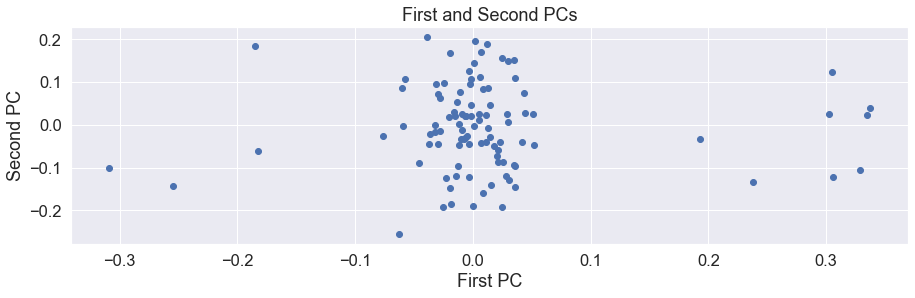

In [31]:
# Plot the first and second PCs
plt.figure(figsize=(15, 4))
plt.scatter(U[:, 0], U[:, 1])
plt.title("First and Second PCs")
plt.xlabel("First PC")
plt.ylabel("Second PC")
plt.show()

# Exercise 1.6

In [32]:
# Compute projected data for both train and test data
X_train_proj = X_train @ U[:, :2]
X_test_proj = X_test @ U[:, :2]

# Creates a model with the projected training data
model = LinearRegression()                 # Creates the model
model = model.fit(X_train_proj, Y_train)   # Trains the model

# Predicts Y_test using the model and X_test_proj as input
Y_test_pred = model.predict(X_test_proj)

# Adds column pcs_ols to df_test with the predicted values
df_test['pcs_ols'] = Y_test_pred.flatten()

# Obtains the R^2 and the mse of the test data
r2 = R2(Y_test, Y_test_pred)
mse = MSE(Y_test, Y_test_pred)

print(f"For the projected test data we have: R^2={r2:.3f} and MSE={mse:.3f}")

For the projected test data we have: R^2=0.214 and MSE=64.241


# Exercise 1.7

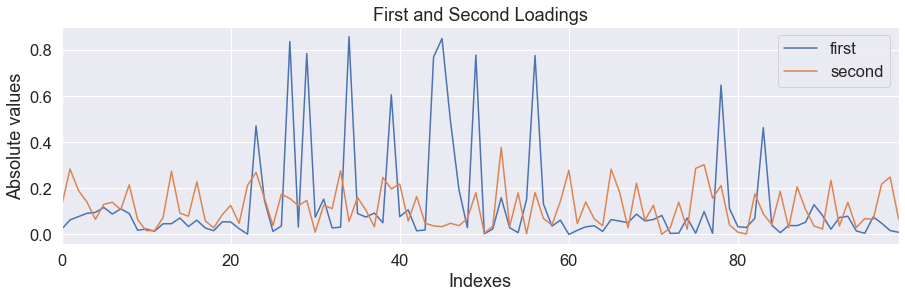

In [33]:
# Compute the absolute values of the loadings on the first two PC
loadings = np.abs(U[:, :2] * np.sqrt(s[:2]))

# Plot the absolute values of the loadings on the first two PC
plt.figure(figsize=(15, 4))
plt.plot(loadings[:, 0], label="first")
plt.plot(loadings[:, 1], label="second")
plt.xlim(0, p-1)
plt.title("First and Second Loadings")
plt.xlabel("Indexes")
plt.ylabel("Absolute values")
plt.legend()
plt.show()

# Exercise 1.8

In [34]:
# Creates a model with the training data
model = LassoCV(eps=1e-4, n_alphas=30, alphas=np.logspace(-3, 1, 30))   # Creates the model (10^-3 = 0.001 <= alphas <= 10^1 = 10)
model = model.fit(X_train, Y_train)                                     # Trains the model

# Predicts Y_test using the model and X_test as input
# We use reshape here because the LassoCV doesn't return Y_pred in the same format as the LinearRegrassion
Y_test_pred = model.predict(X_test).reshape(-1, 1)

# Adds column lasso to df_test with the predicted values
df_test['lasso'] = Y_test_pred.flatten()

# Adds column lasso to df_coef with the estimated coefficients
df_coef['lasso'] = model.coef_.flatten()

# Obtains the R^2 and the mse of the test data
r2 = R2(Y_test, Y_test_pred)
mse = MSE(Y_test, Y_test_pred)

print(f"For the test data using Lasso we have: R^2={r2:.3f} and MSE={mse:.3f}")

For the test data using Lasso we have: R^2=0.577 and MSE=34.597


# Exercise 1.9

In [35]:
# Creates a model with the training data
model = RidgeCV(alphas=np.logspace(-1, 2, 30))   # Creates the model (10^-1 = 0.1 <= alphas <= 10^2 = 100)
model = model.fit(X_train, Y_train)              # Trains the model

# Predicts Y_test using the model and X_test as input
# We use reshape here because the RidgeCV doesn't return Y_pred in the same format as the LinearRegrassion
Y_test_pred = model.predict(X_test).reshape(-1, 1)

# Adds column Ridge to df_test with the predicted values
df_test['Ridge'] = Y_test_pred.flatten()

# Adds column Ridge to df_coef with the estimated coefficients
df_coef['Ridge'] = model.coef_.flatten()

# Obtains the R^2 and the mse of the test data
r2 = R2(Y_test, Y_test_pred)
mse = MSE(Y_test, Y_test_pred)

print(f"For the test data using Ridge we have: R^2={r2:.3f} and MSE={mse:.3f}")

For the test data using Ridge we have: R^2=0.536 and MSE=37.944


# Exercise 1.10

In [42]:
def model_params(Xk_tilde, Y):

    # Defines useful matrixes
    ones = np.ones(Xk_tilde.shape)                # = 1n
    ones_Xk_tilde = np.hstack((ones, Xk_tilde))   # = (1n, Xk_tilde)
    e0 = np.array([[1, 0]]).T                     # 1st element of the orthogonal basis of R^2, e0 = (1 0).T
    e1 = np.array([[0, 1]]).T                     # 2nd element of the orthogonal basis of R^2, e1 = (0 1).T

    # Obtains the dimensions of Xk_tilde
    n, _ = Xk_tilde.shape 
    
    # Creates a model with the training data
    model = LinearRegression()            # Creates the model
    model = model.fit(ones_Xk_tilde, Y)   # Trains the model

    # Gets the coefficients θ(Y, Xk_tilde) and the predicted values (1n, Xk_tilde) @ θ(Y, Xk_tilde) of the model
    coefs = model.coef_.T
    Y_pred = model.predict(ones_Xk_tilde)

    # Calculates the residual matrix r = Y - (1n, Xk_tilde) @ θ(Y, Xk_tilde)
    r = Y - Y_pred

    # Calculates the Gram matrix G(Xk_tilde) = n^-1 * (1n, Xk_tilde).T @ (1n, Xk_tilde) 
    G = (1/n) * ones_Xk_tilde.T @ ones_Xk_tilde

    # Calculates the noise level estimate σ^2(Y, Xk_tilde) = (n-2)^-1 * || Y - (1n, Xk_tilde) @ θ(Y, Xk_tilde) ||^2
    sigma_sqrd = ( 1/(n-2) ) * np.linalg.norm(r)**2
    sigma = np.sqrt(sigma_sqrd)

    # Calculates s^2(Xk_tilde) = e1.T @ G(Xk_tilde)^-1 @ e1 
    s_sqrd = e1.T @ np.linalg.inv(G) @ e1
    s = np.sqrt(s_sqrd)

    # Calculates the test statistics T(Y, Xk_tilde) = n^(1/2) * |θ(Y, Xk_tilde)| / (s(Xk_tilde) * σ(Y, Xk_tilde) )
    T = np.sqrt(n) * np.abs(coefs) / (s*sigma)

    # Calculates the p-value of the estimator p_value = 2*( 1 - Φ(T(Y, Xk_tilde)) )
    p_value = 2*( 1 - sp.stats.norm.cdf(T) )

    # Since we only care about the information regarding θ1 (and not θ0)
    T = T[1][0]
    p_value = p_value[1][0]

    return r, T, p_value


def forward_variable_selection(X, Y, pstop=None):

    # Obtains the dimensions of X
    n, p = X.shape 

    # Defines important variables
    A = [k for k in range(p)]   # Array with the covariates
    S = []                      # Array with the selected covariates (in the right order)
    r = Y                       # Initial condition of the residue
    Ts = []                     # Array with selected test statistics
    p_values = []               # Array with selected p_values

    # Iterates until all variables have been selected (A\S = ∅) or until the loop breaks
    while np.setdiff1d(A, S).tolist():

        # Gets the models params for every remaining covariate (for each k ∈ A\S)
        models_params = [model_params(X_train[:, k].reshape(-1, 1),  r) + (k, ) for k in np.setdiff1d(A, S)]

        # Gets the params of the model where T(Y, Xk_tilde) is max
        r, T, p_value, k_star = max(models_params, key=lambda x: x[1])

        # If the p-value is grater than pstop, breaks the loop
        if pstop:
            if p_value > pstop:
                break

        # Appends k* ∈ argmax T(Y, Xk_tilde) to the selected covariates array
        S.append(k_star)

        # Appends T and p_value to their respective arrays
        Ts.append(T)
        p_values.append(p_value)

    return S, Ts, p_values

In [51]:
S, _, __ = forward_variable_selection(X_train, Y_train)

print(f"The order of the variable selection is: {S}")

The order of the variable selection is: [44, 46, 29, 83, 62, 28, 9, 22, 33, 75, 24, 66, 15, 63, 20, 10, 76, 97, 4, 34, 56, 88, 53, 51, 25, 18, 47, 90, 58, 91, 16, 99, 5, 82, 31, 78, 17, 92, 36, 42, 38, 52, 21, 77, 73, 86, 6, 8, 40, 3, 94, 89, 61, 11, 7, 96, 95, 48, 43, 41, 49, 27, 45, 87, 54, 93, 60, 57, 67, 2, 39, 69, 19, 70, 14, 68, 59, 98, 32, 26, 81, 37, 79, 50, 0, 1, 85, 64, 12, 55, 30, 71, 74, 84, 80, 23, 35, 65, 13, 72]


# Exercise 1.11

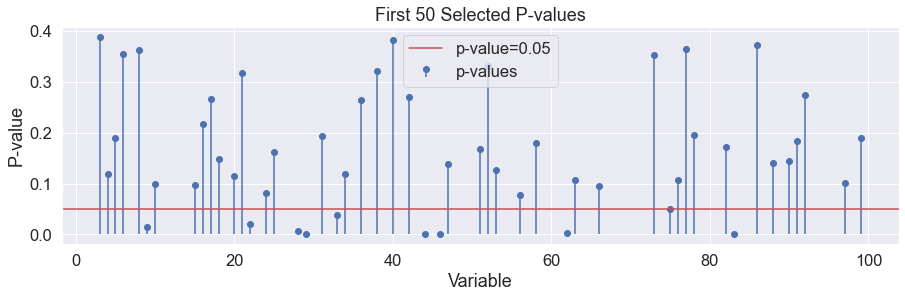

In [76]:
# Obtains selected variables and p-values
S, _, p_values = forward_variable_selection(X_train, Y_train)

# Plot first 50 selected p-values
plt.figure(figsize=(15, 4))
plt.stem(S[:50], p_values[:50], label="p-values", basefmt=' ')
plt.axhline(y=0.05, label="p-value=0.05", color='r', linestyle='-')
plt.title("First 50 Selected P-values")
plt.xlabel("Variable")
plt.ylabel("P-value")
plt.legend(loc=9)
plt.show()

In [41]:
print(f"The order of the variable selection with pstop=0.05 is: {forward_variable_selection(X_train, Y_train, 0.05)}")

The order of the variable selection with pstop=0.05 is: [44, 46, 29, 83, 62, 28, 9, 22, 33, 75]


# Exercise 1.12

In [48]:
# Obtains the indexes of the selected covariates
S, _, __ = forward_variable_selection(X_train, Y_train, 0.05)

# Creates train and test matrices with the selected covariates
X_train_selected = X_train[:, S]
X_test_selected = X_test[:, S]

# Creates a model with the selected training data
model = LinearRegression()                     # Creates the model
model = model.fit(X_train_selected, Y_train)   # Trains the model

# Predicts Y_test using the model and X_test_selected as input
Y_test_pred = model.predict(X_test_selected)

# Adds column Ridge to df_test with the predicted values
df_test['FVS'] = Y_test_pred.flatten()

# Adds column Ridge to df_coef with the estimated coefficients
df_coef['FVS'] = model.coef_.flatten()

# Obtains the R^2 and the mse of the test data
r2 = R2(Y_test, Y_test_pred)
mse = MSE(Y_test, Y_test_pred)

print(f"For the test data using the selected covariates we have: R^2={r2:.3f} and MSE={mse:.3f}")

ValueError: Length of values (10) does not match length of index (100)

# Exercise 1.13

# Exercise 1.14

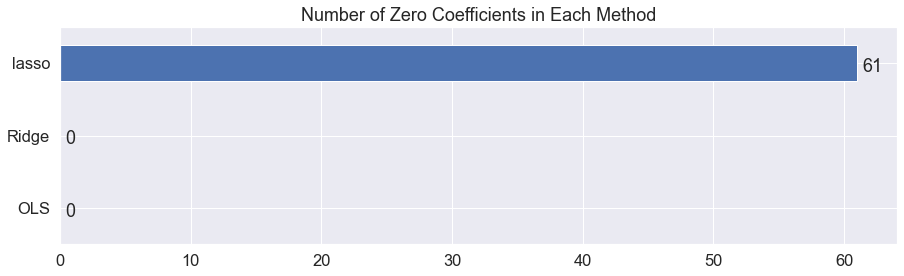

In [39]:
# Plots the number of zero coefficients in each method
ax = df_coef.agg(lambda row: row.eq(0).sum()).sort_values().plot(
    kind = "barh", 
    figsize = (15, 4),
    title = "Number of Zero Coefficients in Each Method"
)
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 10), textcoords='offset points')

As we can see from the plot above, the number of coefficients set to zero using Lasso is way bigger than the one using the Ridge. This happends because **AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA**

# Exercise 1.15